#**VGG Style Convolutional Neural Network Classifier for CIFAR10 Dataset**

  Kamran Naveed Syed |    266897  |  SEECS   
  Muhammad Abdullah  |  267911 |  SEECS 


###**NOTE: PLEASE ALLOW UPTO 12 MINUTES TO RUN**

The convolutional neural network classifier will be trained on CIFAR-10 dataset.

**LIBRARIES USED**

Following libraries will be used in training the model


*   Tensorflow 
*   Numpy
* Sci-kit Learn
*   Matplotlib
* Seaborn
*   Random


##**Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import tensorflow as tf
from tensorflow.keras import models, layers, datasets, regularizers, optimizers
from keras.preprocessing.image import ImageDataGenerator


##  **Visualization**







The CIFAR-10 dataset consists of **60000 32x32** colour images in 10 classes, with **6000** images per class. There are **50000 training images** and **10000 test images.**

CIFAR-10 dataset is already preloaded in keras, thus we only have to import it. Importing it returns a tuple of numpy array dividing the dataset into training and test batches.

Samples from each class are shown as an insanity check. We can see that the dataset conatins images which are small (32x32 px) and do not have good resolution when displayed.

The labels for the 10 classes are as follows:
* airplane : 0
* automobile : 1
* bird : 2
* cat : 3
* deer : 4
* dog : 5
* frog : 6
* horse : 7
* ship : 8
* truck : 9

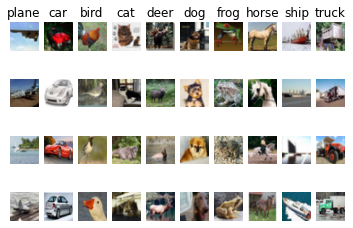

In [ ]:
#Load the pre-loaded dataset from keras
(train_images_full, train_labels_full), (test_images, test_labels) = datasets.cifar10.load_data() 

#Class details
classes = [ 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

#Plot n samples of each class
samples = 4
for y, class_name in enumerate(classes):
    indexes = np.flatnonzero(train_labels_full == y)
    indexes = np.random.choice(indexes, samples, replace=False)
    for i, index in enumerate(indexes):
        plt_index = i * num_classes + y + 1
        plt.subplot(samples, num_classes, plt_index)
        plt.imshow(train_images_full[index].astype('uint32'))
        plt.axis('off')
        if i == 0:
            plt.title(class_name)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import tensorflow as tf
from tensorflow.keras import models, layers, datasets, regularizers
tf.random.set_seed(5)

##**Preprocessing**

The original training dataset is further divided into validation data set and training dataset.

* The validation batch will have **10000** images taken from the original training batch
* The training batch for the model will have **40000** images
* The testing set will have **10000** images


In [ ]:
# Define fraction to separate into training, testing and validation sets

val_split = 0.3 #This will be used while training the models

print("Total Training images in original dataset: %d"% train_images_full.shape[0])
print("Training images used in model: %d"% (train_images_full.shape[0]*(1-val_split)))
print("Validation images: %d"% (train_images_full.shape[0]*val_split))
print("Testing images: %d"% test_images.shape[0])
print("Image sizes: %d x %d px with %d RGB colours each" % train_images_full.shape[1:])


Total Training images in original dataset: 50000
Training images used in model: 35000
Validation images: 15000
Testing images: 10000
Image sizes: 32 x 32 px with 3 RGB colours each


**Normalization**

The data is then normalizedin the range (0,1) by dividing each value by 255, since 255 is the maximum value for RGB. 

Normalisation of data in the range (0,1) is done because, in probability theory, which is the foundation of machine learning, probability is measured in this range. Therefore, it is more convenient and should improve the activation function's performance later on for eg. the sigmoid function works more efficiently with data range 0.0-1.0. We normalise both train and test data.

However, normalization does not improve performances in all cases, but is a good habit nonetheless.

In [ ]:
#Normalizing in the range (0,1) for improved performance, using 255 as it is max value of RGB
train_images_full = np.float32(train_images_full/255.0) #converted to float types for better accuracy
test_images = np.float32( test_images/255.0)

A custom function is defined which will help us assess the performance of our model later on

In [ ]:
#Defining a function for evaluation of each model
def plot_evaluations(model_history,epochs_):
  ''' This function plots Validation losses and accuracies, and Training losses and accuracies against epochs traversed'''
  
  plt.subplot(121)
  acc_ = model_history.history['accuracy']
  val_acc_ = model_history.history['val_accuracy']
  epochs = [epoch for epoch in range(1,epochs_+1)]
  plt.plot(epochs, acc_,label = 'Training Accuracy', c='r')
  plt.plot(epochs, val_acc_,label = 'Validation Acurracy', c='b')
  plt.legend(loc = 'upper right', bbox_to_anchor=(1.5, 0, 0.5, 0.5))
  plt.title('Accuracy Plot')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0)
  plt.show()

  plt.subplot(122)
  loss_ = model_history.history['loss']
  val_loss_ = model_history.history['val_loss']
  epochs = [epoch for epoch in range(1,epochs_+1)]
  plt.plot(epochs, loss_,label = 'Training Loss', c='r')
  plt.plot(epochs, val_loss_,label = 'Validation Loss', c='b')
  plt.legend(loc = 'upper right', bbox_to_anchor=(1.5, 0, 0.5, 0.5))
  plt.title('Loss Plot')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.ylim(ymin=0)
  plt.show()

## **Optimizing and evaluating the Classifier**

In [ ]:
epochs_ = 20 #number of epochs used in each variation

###**Variation 1: Baseline CNN**

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

A baseline VGG model for convolutional neural network is implemented using the *VGG* architecture.

**Breakdown**

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width of the output feature maps matches the inputs.

The model is optimized using stochastic gradient descent, `SGD` with learning rate 0.01 and momentum 0.9.

Let us establish a basleine using one VGG Block



In [ ]:
model1 = models.Sequential([
                        
                        #1 VGG-Block
                        layers.Conv2D(filters = 32 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same', input_shape = (32,32,3)),
                        layers.Conv2D(filters = 32 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same'),

                        layers.MaxPooling2D((2,2)),
                         
                        layers.Flatten(),
                        layers.Dense(64, activation = 'relu'),
                        layers.Dense(32, activation = 'relu'),
                        layers.Dense(10, activation = 'softmax')
])

#Compile
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(optimizer = sgd,
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

#Train
model1_history = model1.fit(train_images_full,train_labels_full,epochs = epochs_,  validation_split=val_split)

Epoch 1/20
1094/1094 [==============================] - 7s 4ms/step - loss: 2.3080 - accuracy: 0.0973 - val_loss: 2.3038 - val_accuracy: 0.0983
Epoch 2/20
1094/1094 [==============================] - 4s 4ms/step - loss: 2.3037 - accuracy: 0.0979 - val_loss: 2.3027 - val_accuracy: 0.1014
Epoch 3/20
1094/1094 [==============================] - 4s 4ms/step - loss: 2.3033 - accuracy: 0.0998 - val_loss: 2.3035 - val_accuracy: 0.0983
Epoch 4/20
1094/1094 [==============================] - 4s 4ms/step - loss: 2.3031 - accuracy: 0.0989 - val_loss: 2.3029 - val_accuracy: 0.1026
Epoch 5/20
1094/1094 [==============================] - 4s 4ms/step - loss: 2.2494 - accuracy: 0.1242 - val_loss: 1.5161 - val_accuracy: 0.4363
Epoch 6/20
1094/1094 [==============================] - 4s 4ms/step - loss: 1.4023 - accuracy: 0.4795 - val_loss: 1.1655 - val_accuracy: 0.5883
Epoch 7/20
1094/1094 [==============================] - 4s 4ms/step - loss: 1.0577 - accuracy: 0.6247 - val_loss: 1.0933 - val_accuracy:

KeyboardInterrupt: ignored

We now evaluate the model:

In [ ]:
plot_evaluations(model1_history,epochs_)

It is observed that we are already off to a better start in terms of accuracy than was the case with the simple neural network, but the basleine model for our CNN also suffers from overfitting.

It can be seen that accuracy and losses diverge for training and validation sets after around 10 epochs. Final training accuracy is 95.21% while the final validation accuracy is 62.23%.

The testing accuracy for this overfitted model is as follows, and is not a true representation of a precise accuracy.

In [ ]:
loss1, accuracy1 = model1.evaluate(test_images, test_labels)
print('\nTesting Accuracy = %.2f %%' % (accuracy1*100))
print('Testing Loss = %.2f' % loss1)



###**Variation 2: Adding more VGG Blocks**

Next, we examine the effect of adding another VGG Block to our model for a deeper network. It is expected that the accuracy will increase.

In [ ]:
model2 = models.Sequential([
                        
                        #2 VGG-Block
                        layers.Conv2D(filters = 32 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same', input_shape = (32,32,3)),
                        layers.Conv2D(filters = 32 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same'),

                        layers.MaxPooling2D((2,2)),

                        layers.Conv2D(filters = 64 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same'),
                        layers.Conv2D(filters = 64 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same'),

                        layers.MaxPooling2D((2,2)),
                         
                        layers.Flatten(),
                        layers.Dense(64, activation = 'relu'),
                        layers.Dense(32, activation = 'relu'),
                        layers.Dense(10, activation = 'softmax')
])

#Compile
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(optimizer = sgd,
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

#Train
model2_history = model2.fit(train_images_full,train_labels_full,epochs = epochs_,  validation_split=val_split)

We now evaluate the model:

In [ ]:
plot_evaluations(model2_history,epochs_)

As per our original assumption, the accuracy has improved. The model, however, still suffers from overfitting.

In [ ]:
loss2, accuracy2 = model2.evaluate(test_images, test_labels)
print('\nTesting Accuracy = %.2f %%' % (accuracy2*100))
print('Testing Loss = %.2f' % loss2)



###**Variation 3: Weight Regularization**



The model is updated using L2 regularization technique and a `Dropout` layer, discussed in the neural network model in our project, and two more VGG Blocks are added

In [ ]:
l2_alpha = 0.001 #good point
drop_rate = 0.2 #good point

model3 = models.Sequential([
                         #3 VGG-Block
                        layers.Conv2D(filters = 32 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha), input_shape = (32,32,3)),
                        layers.Conv2D(filters = 32 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha)),

                        layers.MaxPooling2D((2,2)),

                        layers.Conv2D(filters = 64 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha)),
                        layers.Conv2D(filters = 64 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha)),

                        layers.MaxPooling2D((2,2)),

                        layers.Conv2D(filters = 128 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha)),
                        layers.Conv2D(filters = 128 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha)),

                        layers.MaxPooling2D((2,2)),
                         
                        layers.Flatten(),
                        layers.Dense(64, activation = 'relu'),
                        layers.Dense(32, activation = 'relu'),
                        layers.Dropout(drop_rate, noise_shape=None, seed=None), #Dropout layer
                        layers.Dense(10, activation = 'softmax')
])

#Compile
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(optimizer = sgd,
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

#Train
model3_history = model3.fit(train_images_full,train_labels_full,epochs = epochs_,  validation_split=val_split)

We now evaluate the model:

In [ ]:
plot_evaluations(model3_history,epochs_)

Significant improvement has been made in the baseline model of our CNN. But it is still not upto the mark.

In [ ]:
loss3, accuracy3 = model3.evaluate(test_images, test_labels)
print('\nTesting Accuracy = %.2f %%' % (accuracy3*100))
print('Testing Loss = %.2f' % loss3)



## **Further Improvements**

Although, in our previous discussion, we were able to improve the performance of our network, the problem of overfitting is still great enough to be left unnoticed. We strive for further improvements in our model

###**Variation of Dropout and Batch Normalization**

We have seen in our previous discussions that dropout works well for the performance of our model. Let us experiment by varying the amount of dropout and adding in more dropout layers. We also add Batch Normalization in hopes of improving the performance.

In [ ]:
l2_alpha = 0.001 #good point

model4 = models.Sequential([
                         #3 VGG-Block
                        layers.Conv2D(filters = 32 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha), input_shape = (32,32,3)),
                        layers.BatchNormalization(),
                        layers.Conv2D(filters = 32 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha)),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D((2,2)),
                        layers.Dropout(0.3, noise_shape=None, seed=None),


                        layers.Conv2D(filters = 64 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha)),
                        layers.BatchNormalization(),
                        layers.Conv2D(filters = 64 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha)),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D((2,2)),
                        layers.Dropout(0.3, noise_shape=None, seed=None),


                        layers.Conv2D(filters = 128 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha)),
                        layers.BatchNormalization(),
                        layers.Conv2D(filters = 128 ,kernel_size = (3,3),activation = 'relu',kernel_initializer='he_uniform', padding='same',kernel_regularizer=regularizers.l2(l2_alpha)),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D((2,2)),
                        layers.Dropout(0.4, noise_shape=None, seed=None),

                         
                        layers.Flatten(),
                        layers.Dense(64, activation = 'relu'),
                        layers.BatchNormalization(),
                        layers.Dense(32, activation = 'relu'),
                        layers.BatchNormalization(),
                        layers.Dropout(drop_rate, noise_shape=None, seed=None), #Dropout layer
                        layers.Dense(10, activation = 'softmax')
])


#Compile
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model4.compile(optimizer = sgd,
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

#Train
model4_history = model4.fit(train_images_full,train_labels_full,epochs = epochs_,  validation_split=val_split)

We now evaluate the model

In [ ]:
plot_evaluations(model4_history,epochs_)

The plots show improvement in the generalisation, as accuracy and loss plots are trying to follow each other. They, however, still overshoot at points. We now aim to smooth them out.

In [ ]:
loss4, accuracy4 = model4.evaluate(test_images, test_labels)
print('\nTesting Accuracy = %.2f %%' % (accuracy4*100))
print('Testing Loss = %.2f' % loss4)





###**Tuning Optimizer**

Maybe the single most important thing that can be done to improve both accuracy and reduce overfitting is to tune the pptimizer hyperparameters. The learning rate, decay and momentum of stochastic gradint descent are tuned and the changes are examined.

In [ ]:
model5 = model4 #no changes required in model
sgd = optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
model5.compile(optimizer = sgd,
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

model5_history = model5.fit(train_images_full, train_labels_full, epochs=epochs_, validation_split=val_split)


We now evaluate the model

In [ ]:
plot_evaluations(model5_history,epochs_)

Including Data Augmentation in our CNN has improved the accuracy by alot, but still the model is not generalising so well as indicated by the plots. We will try to smooth this out.

In [ ]:
loss5, accuracy5 = model4.evaluate(test_images, test_labels)
print('\nTesting Accuracy = %.2f %%' % (accuracy5*100))
print('Testing Loss = %.2f' % loss5)



##**Final Evaluations**



###**Confusion Matrix**


A confusion matrix is a perfect method to evaluate the performance of the model. Making the confusion matrix of the results of the testing data set can help us understand the accuracy.

In [ ]:
predicted = model2.predict(test_images)
predicted_labels = [np.argmax(i) for i in predicted]
cm = tf.math.confusion_matrix(labels= test_labels, predictions= predicted_labels)

plt.figure(figsize= (10,7))
sn.heatmap(cm,annot=True, fmt='d',xticklabels = classes , yticklabels = classes,cmap="OrRd")
plt.xlabel('PREDICTED')
plt.ylabel('ORIGINAL')

###**Random testing**

Random testing is applied for a better understanding of how correctly our model has labelled data

In [ ]:
sample_size = 1000
correct = 0
incorrect = 0
test_labels_plot = test_labels.reshape((-1,))


for i in range(int(sample_size)):
  x = np.random.randint(0,10000)
  if classes[test_labels_plot[x]] == classes[predicted_labels[x]]:
    correct+=1
  else:
    incorrect +=1

print('Out of %d randomly sampled images:' % sample_size)
print('\n\t %d are correctly labelled' % correct)
print('\n\t %d are wrongly labelled' % incorrect)
print('\nTesting accuracy was %d %%' % (accuracy*100))
print('\n\nSome images are shown below with the original and predicted labels:\n\n')

for i in range(int(sample_size/200)):
  x = np.random.randint(0,10000)
  plt.figure(figsize=(2,2))
  plt.imshow(test_images[x])
  plt.xlabel(classes[test_labels_plot[x]])
  plt.title('ORIGINAL')
 
  plt.figure(figsize=(2,2))
  plt.imshow(test_images[x])
  plt.xlabel(classes[predicted_labels[x]])
  plt.title('PREDICTED')


